In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Union, Optional, Callable
from dataclasses import dataclass
import math
import numpy.typing as npt
from scipy import stats
import scipy.stats as st         # type: ignore
import scipy.optimize as opt     # type: ignore
import scipy.integrate as intg   # type: ignore
import scipy.special as spec     # type: ignore
import scipy.misc as spmisc      # type: ignore

[*********************100%***********************]  1 of 1 completed


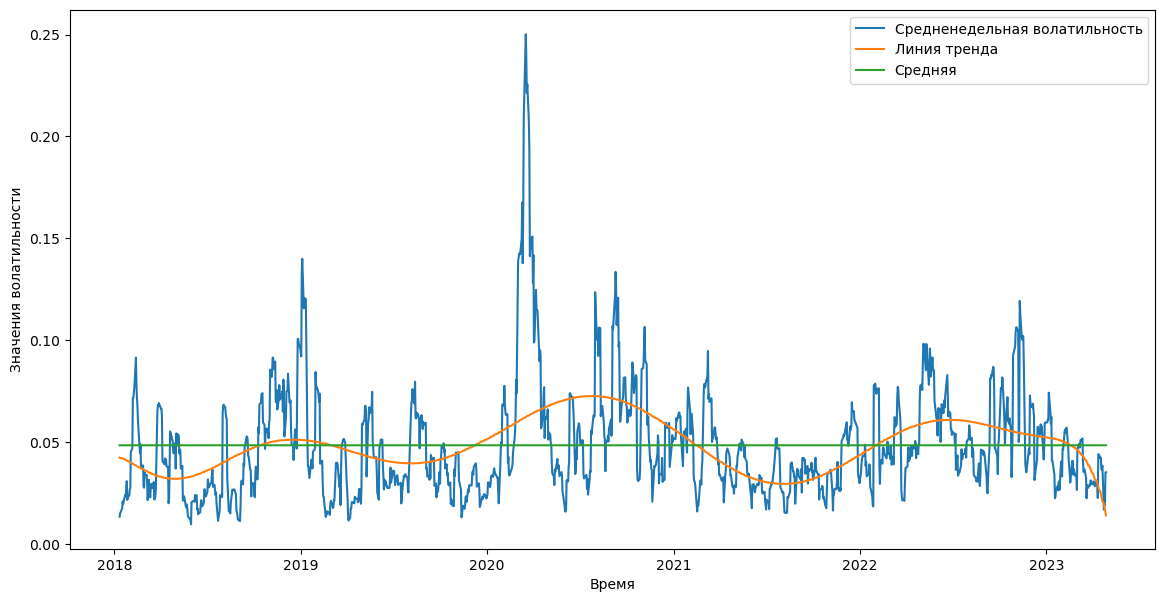

In [2]:
#Mean-reverting of volatility
import yfinance as yf

aapl = yf.download("AAPL", start="2018-01-01")
price = aapl["Adj Close"]
ret = price.pct_change()
vol = ret.rolling(7).std().dropna() * np.sqrt(7)

z = np.polyfit(np.arange(vol.shape[0]), vol.values, 10)
p = np.poly1d(z)
mean_vol = np.mean(vol)
x = np.arange(vol.shape[0])
mean_vol_arr = mean_vol * np.ones(vol.shape[0])
plt.figure(figsize=(14, 7))
plt.plot(vol.index, vol.values, label="Средненедельная волатильность")
plt.plot(vol.index, p(x), label="Линия тренда")
plt.plot(vol.index, mean_vol_arr, label="Средняя")
plt.xlabel("Время")
plt.ylabel("Значения волатильности")
plt.legend()

In [3]:
aapl = yf.download("GOOG", start="2019-01-01", end="2023-01-01")
price = aapl["Adj Close"]
ret = price.pct_change()
vol = ret.rolling(252).std().dropna() * np.sqrt(252)
print("Среднегодовая волатильность = ", np.mean(vol))

[*********************100%***********************]  1 of 1 completed
Среднегодовая волатильность =  0.3113318798700725


In [4]:
# Realization of Monte Carlo class
FloatArray = npt.NDArray[np.float_]
Floats = Union[float, FloatArray]

@dataclass
class MC:
    x: float
    error: float
    conf_prob: float
    success: bool
    iterations: int
    control_coef: Optional[float] = None
        
def monte_carlo(simulator: Callable[[int], npt.NDArray[np.float_]],
                f: Callable[[npt.NDArray[np.float_]], npt.NDArray[np.float_]],
                abs_err: float = 1e-3,
                rel_err: float = 1e-3,
                conf_prob: float = 0.95,
                batch_size: int = 1000,
                max_iter: int = 1000000,
                control_f: Optional[Callable[[npt.NDArray[np.float_]], npt.NDArray[np.float_]]] = None,
                control_estimation_iter: int = 5000) -> MC:
    
        x: float = 0 # current mean
        sigma: float = 0 # current standard error
        n: int = 0 # amount of batches
        theta: Optional[float] = None # control variate coefficient
        z : float = stats.norm.ppf((1 + conf_prob) / 2)
        x_sq: float = 0 # curent mean of squares
            
        
        if control_f is not None:
            S = simulator(control_estimation_iter)
            
            covariance = np.cov(f(S), control_f(S))
            theta = covariance[0, 1] / covariance[1, 1]
            
        
        while (n == 0  or (
               z * sigma / np.sqrt(batch_size * n) > abs_err + abs(x) * rel_err and max_iter > n * batch_size)):
            
            S = simulator(batch_size)

            y = f(S) - theta * control_f(S) if control_f is not None else f(S)
            
            x  = (x * n + np.mean(y)) / (n + 1)
            
            x_sq = (x_sq * n + np.mean(y**2)) / (n + 1)
            sigma = np.sqrt(x_sq - x**2)
            
            n += 1
        return MC(x=x,
                  error=z*sigma/np.sqrt(batch_size*n),
                  conf_prob=conf_prob,success=(max_iter > n * batch_size),
                  iterations=n*batch_size,
                  control_coef=theta)

In [5]:
# Euler and OU schemes for discretization
@dataclass
class ExpOU:
    
    s: float
    v: float
    mu: float
    kappa: float
    sigma: float
    alfa: float
    theta: float
    beta: float
    rho: float
    r: float = 0
       



    def simulate_euler(self, t: float, steps: int, paths: int, return_v: bool = False) -> Union[np.ndarray, tuple[np.ndarray, np.ndarray]]:
        dt = t/steps
        S = np.empty((steps+1, paths))
        V = np.empty((steps+1, paths))
        S[0] = self.s
        V[0] = self.v
        Z = np.random.randn(2, steps, paths)
        for i in range(steps):
            v_plus = np.maximum(V[i], 0)
            V[i+1] = V[i] + V[i]*(-self.alfa*np.log(V[i]) + 0.5*self.beta**2 - self.beta*self.rho*(self.mu + self.kappa * i * dt)/self.sigma + self.theta)*dt + V[i]*self.beta*Z[0, i]*math.sqrt(dt)
            S[i+1] = S[i]*np.exp(V[i]*(self.rho*Z[0, i] + math.sqrt(1-self.rho**2)*Z[1, i])*np.sqrt(dt))
        if return_v:
            return (S,V)
        else:
            return S
        
    
    def simulate_OU(self, t: float, steps: int, paths: int, return_v: bool = False) -> Union[np.ndarray, tuple[np.ndarray, np.ndarray]]:
        dt = t/steps
        S = np.empty((steps+1, paths))
        V = np.empty((steps+1, paths))
        S[0] = self.s
        V[0] = self.v
        Z = np.random.randn(2, steps, paths)
        ZZ = np.random.randn(1, steps+1, paths)
        k = 0
        c_1 = (self.theta-self.alfa*np.log(self.sigma) - self.beta*self.rho*self.mu / self.sigma) / self.alfa
        c_2 = self.beta*self.rho*self.kappa / (self.sigma * self.alfa**2)
        for i in range(steps):
            tau = dt*(i+1)
            g = np.log(self.v/self.sigma)*np.exp(-self.alfa*tau) + c_1*(1 - np.exp(-self.alfa*tau)) - c_2*(self.alfa*t - 1 + np.exp(-self.alfa*tau))
            k = np.sqrt(self.beta**2/(2*self.alfa)*(1-np.exp(-2*self.alfa*tau)))
            x = ZZ[0, i+1]*np.sqrt(k) + g
            V[i + 1] = self.sigma*np.exp(x)
            S[i+1] = S[i]*np.exp(V[i]*(self.rho*Z[0, i] + math.sqrt(1-self.rho**2)*Z[1, i])*np.sqrt(dt))
        if return_v:
            return (S,V)
        else:
            return S


In [15]:
model = ExpOU(s = 1, v = 0.3, mu = 0.5, kappa = 0, sigma = 0.05, alfa = 0.5, theta = 0.2, beta = 0.4, rho = 0.25)

In [16]:
t = 1
steps = 200
paths = 25
S, V = model.simulate_euler(t,steps,paths,return_v = True)

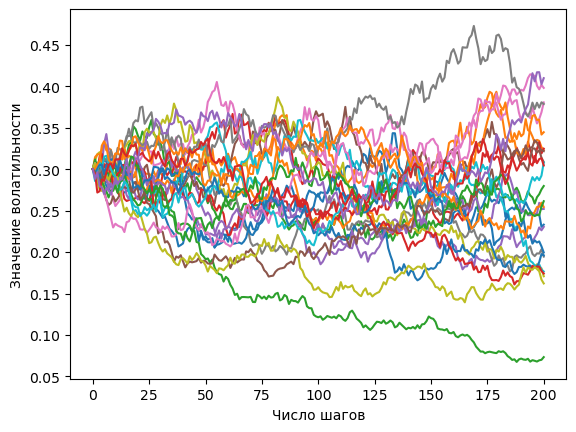

In [17]:
plt.plot(V)
plt.xlabel("Число шагов")
plt.ylabel("Значение волатильности")
#plt.title('STD paths, euler method')
plt.show()

In [18]:
K = 1
steps = 100
def payoff(S: FloatArray):
    return np.maximum(S[-1] - K, 0)

res1 = monte_carlo(simulator = lambda paths: model.simulate_euler(t, steps, paths), 
                   f = lambda S: payoff(S),
                   rel_err = 0.001,
                   control_f = lambda S: S[-1] - np.mean(S[-1]))

In [19]:
res1

MC(x=0.14249792674830936, error=0.0011363230127750088, conf_prob=0.95, success=True, iterations=25000, control_coef=0.7104613257016742)

0.5
0.51010101010101
0.5202020202020202
0.5303030303030303
0.5404040404040404
0.5505050505050505
0.5606060606060606
0.5707070707070707
0.5808080808080808
0.5909090909090909
0.601010101010101
0.6111111111111112
0.6212121212121212
0.6313131313131313
0.6414141414141414
0.6515151515151515
0.6616161616161617
0.6717171717171717
0.6818181818181819
0.6919191919191919
0.702020202020202
0.7121212121212122
0.7222222222222222
0.7323232323232324
0.7424242424242424
0.7525252525252526
0.7626262626262627
0.7727272727272727
0.7828282828282829
0.7929292929292929
0.803030303030303
0.8131313131313131
0.8232323232323233
0.8333333333333334
0.8434343434343434
0.8535353535353536
0.8636363636363636
0.8737373737373737
0.8838383838383839
0.893939393939394
0.9040404040404041
0.9141414141414141
0.9242424242424243
0.9343434343434344
0.9444444444444444
0.9545454545454546
0.9646464646464648
0.9747474747474748
0.9848484848484849
0.994949494949495
1.0050505050505052
1.0151515151515151
1.0252525252525253
1.0353535353535

Text(0, 0.5, 'Call price')

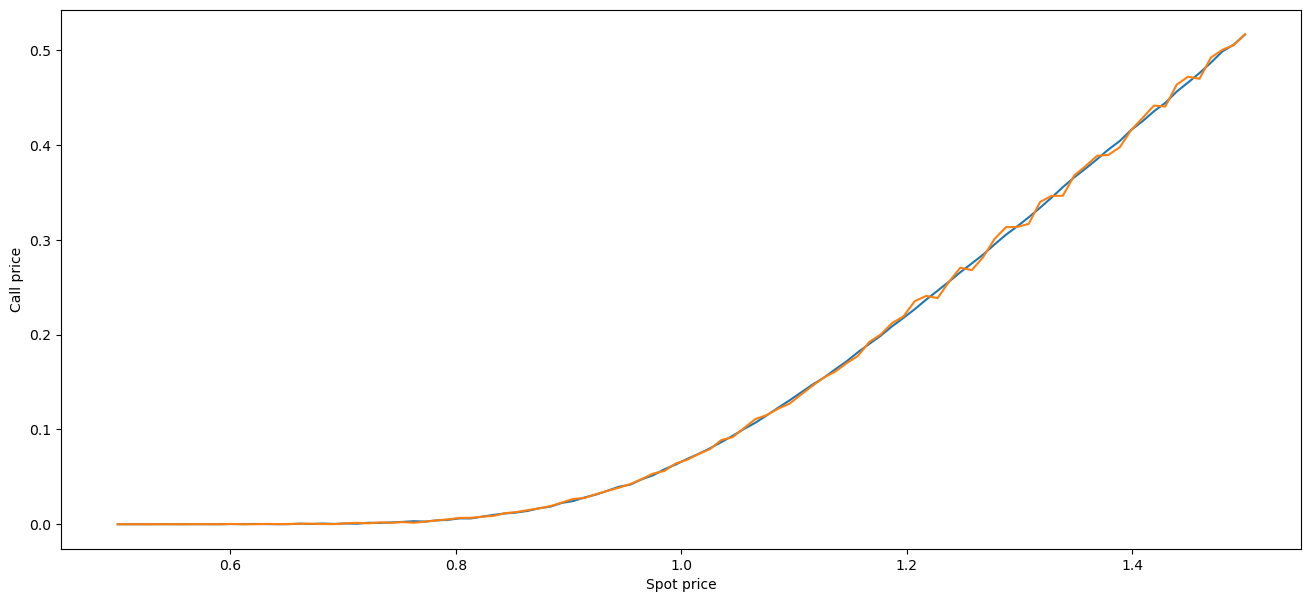

In [20]:
steps = 100
S_0 = np.linspace(0.5, 1.5, steps)
#T = [0, 0.25, 0.5, 0.75, 1]
T_lst = [0.25, 0.5, 1]
T = 0.25
#for t in T:
times = np.linspace(0, T, steps)
c1 = []
c2 = []
for s_0 in S_0:
    print(s_0)
    model = ExpOU(s = s_0, v = 0.3, mu = 0.5, kappa = 0, sigma = 0.05, alfa = 0.5, theta = 0.2, beta = 0.4, rho = 0.25)
    S, V = model.simulate_euler(T,steps,paths,return_v = True)
    res1 = monte_carlo(simulator = lambda paths: model.simulate_euler(T, steps, paths), 
                       f = lambda S: payoff(S),
                       rel_err = 0.001)
    res2 = monte_carlo(simulator = lambda paths: model.simulate_euler(T, steps, paths), 
                       f = lambda S: payoff(S),
                       rel_err = 0.001,
                       control_f = lambda S: S[-1] - np.mean(S[-1]))
    c1.append(res1.x)
    c2.append(res2.x)
c1 = np.array(c1)
c2 = np.array(c2)
print("Diff arr: ", c2 - c1)
print("Err: ", np.mean((c2 - c1)**2))
c_euler = np.array(c1)

plt.figure(figsize=(16, 7))
plt.plot(S_0, c1)
plt.plot(S_0, c2)
plt.xlabel("Spot price")
plt.ylabel("Call price")

In [44]:
model = ExpOU(s = 1, v = 0.3, mu = 0.5, kappa = 0, sigma = 0.05, alfa = 0.5, theta = 0.2, beta = 0.4, rho = 0.25)

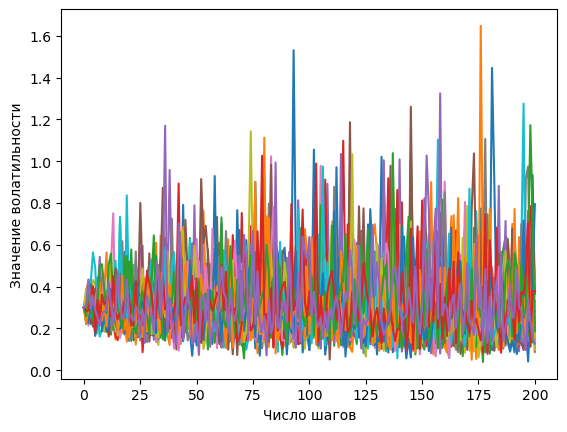

In [46]:
t = 1
steps = 200
paths = 25
S, V = model.simulate_OU(t,steps,paths,return_v = True)

plt.plot(V)
plt.xlabel("Число шагов")
plt.ylabel("Значение волатильности")
#plt.title('STD paths, OU sampling method')
plt.show()

In [29]:
K = 1
steps = 100
def payoff(S: FloatArray):
    return np.maximum(S[-1] - K, 0)

res1 = monte_carlo(simulator = lambda paths: model.simulate_OU(t, steps, paths), 
                   f = lambda S: payoff(S),
                   rel_err = 0.001,
                   control_f = lambda S: S[-1] - np.mean(S[-1]))
res1

MC(x=0.17360368282082647, error=0.0011639980933064182, conf_prob=0.95, success=True, iterations=30000, control_coef=0.7007793573071094)

Text(0, 0.5, 'Цена опциона')

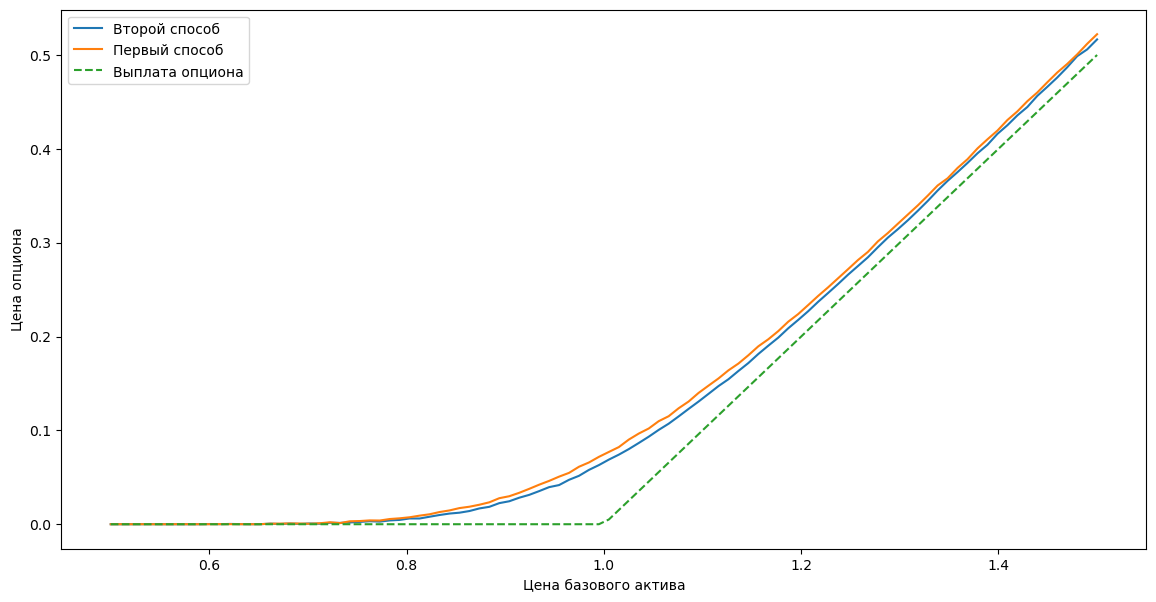

In [30]:
steps = 100
S_0 = np.linspace(0.5, 1.5, steps)
#T = [0, 0.25, 0.5, 0.75, 1]
T_lst = [0.25, 0.5, 1]
T = 0.25
#for t in T:
times = np.linspace(0, T, steps)
c = []
for s_0 in S_0:
    model = ExpOU(s = s_0, v = 0.3, mu = 0.5, kappa = 0, sigma = 0.05, alfa = 0.5, theta = 0.2, beta = 0.4, rho = 0.25)
    S, V = model.simulate_OU(T, steps, paths, return_v = True)
    res1 = monte_carlo(simulator = lambda paths: model.simulate_OU(T, steps, paths), 
                       f = lambda S: payoff(S),
                       rel_err = 0.001)
                       #control_f = lambda S: S[-1] - np.mean(S[-1]))
    c.append(res1.x)
c = np.array(c)

c_theor = [S_0[i] - K if S_0[i] > K else 0 for i in range(steps)]
plt.figure(figsize=(14, 7))
plt.plot(S_0, c_euler, label="Второй способ")
plt.plot(S_0, c, label="Первый способ")
plt.plot(S_0, np.array(c_theor), linestyle="--", label="Выплата опциона")
plt.legend()
plt.xlabel("Цена базового актива")
plt.ylabel("Цена опциона")

In [31]:
print(np.mean(abs(c_euler - c)))

0.004414190647060998


In [33]:
#Сравнение скорости работы двух способов
import time

steps = 200
paths = 50
S_0 = np.linspace(0.5, 1.5, steps)
T = 0.5

#Euler with control variate
start = time.time()
c = []
for s_0 in S_0:
    model = ExpOU(s = s_0, v = 0.3, mu = 0.5, kappa = 0, sigma = 0.05, alfa = 1, theta = 0.2, beta = 0.4, rho = 0.25)
    res1 = monte_carlo(simulator = lambda paths: model.simulate_euler(T, steps, paths), 
                       f = lambda S: payoff(S),
                       rel_err = 0.001,
                       control_f = lambda S: S[-1] - np.mean(S[-1]))
    c.append(res1.x)
c = np.array(c)
diff = time.time() - start
print("Euler (control variate) time: ", diff)

#OU
start = time.time()
c = []
for s_0 in S_0:
    model = ExpOU(s = s_0, v = 0.3, mu = 0.5, kappa = 0, sigma = 0.05, alfa = 1, theta = 0.2, beta = 0.4, rho = 0.25)
    res1 = monte_carlo(simulator = lambda paths: model.simulate_OU(T, steps, paths), 
                       f = lambda S: payoff(S),
                       rel_err = 0.001)
    c.append(res1.x)
c = np.array(c)
diff = time.time() - start
print("OU time: ", diff)

#Euler
start = time.time()
c = []
for s_0 in S_0:
    model = ExpOU(s = s_0, v = 0.3, mu = 0.5, kappa = 0, sigma = 0.05, alfa = 1, theta = 0.2, beta = 0.4, rho = 0.25)
    res1 = monte_carlo(simulator = lambda paths: model.simulate_euler(T, steps, paths), 
                       f = lambda S: payoff(S),
                       rel_err = 0.001)
    c.append(res1.x)
c = np.array(c)
diff = time.time() - start
print("Euler time: ", diff)

Euler (control variate) time:  49.51823592185974
OU time:  613.4509329795837
Euler time:  430.63168001174927


0


/var/folders/fw/5s9pnm2d27lfvkv814ljhz2c0000gn/T/ipykernel_39012/2171299531.py:49: RuntimeWarning: invalid value encountered in sqrt
  sigma = np.sqrt(x_sq - x**2)


0.25
0.5
0.75
1


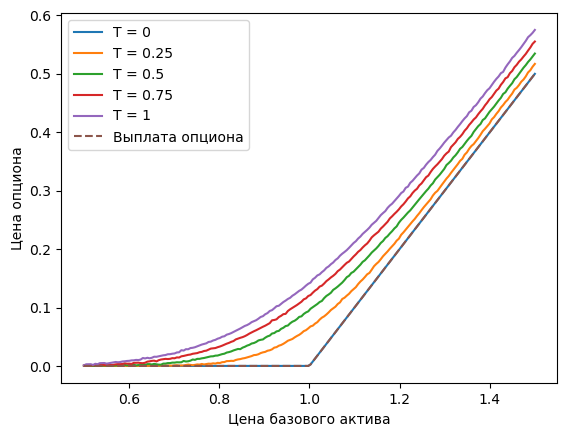

In [34]:
#Зависимость от даты экспирации
T = [0, 0.25, 0.5, 0.75, 1]
steps = 200
S_0 = np.linspace(0.5, 1.5, steps)
c = []
c_t = []
for t in T:
    c = []
    print(t)
    for s_0 in S_0:
        model = ExpOU(s = s_0, v = 0.3, mu = 0.5, kappa = 0, sigma = 0.05, alfa = 0.5, theta = 0.2, beta = 0.4, rho = 0.25)
        S, V = model.simulate_euler(t, steps, paths, return_v = True)
        res1 = monte_carlo(simulator = lambda paths: model.simulate_euler(t, steps, paths), 
                           f = lambda S: payoff(S),
                           rel_err = 0.001)
        c.append(res1.x)
    c = np.array(c)
    plt.plot(S_0, c, label="T = {0}".format(t))
c_theor = [S_0[i] - K if S_0[i] > K else 0 for i in range(steps)]
plt.xlabel("Цена базового актива")
plt.ylabel("Цена опциона")
plt.plot(S_0, np.array(c_theor), linestyle="--", label="Выплата опциона")
plt.legend()
plt.show()

0.1
0.5
1
1.5
2


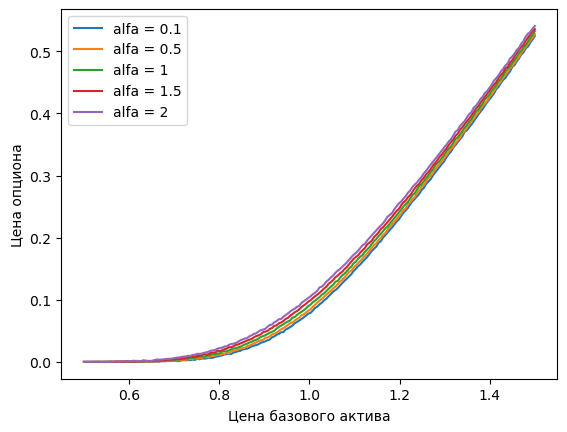

In [91]:
#Зависимость от параметра mean-reverting
T = 0.25
steps = 200
S_0 = np.linspace(0.5, 1.5, steps)
c = []
alfa_lst = [0.1, 0.5, 1, 1.5, 2]
for a in alfa_lst:
    c = []
    print(a)
    for s_0 in S_0:
        model = ExpOU(s = s_0, v = 0.3, mu = 1, kappa = 0, sigma = 1, alfa = a, theta = 0.2, beta = 0.4, rho = 0.25)
        res1 = monte_carlo(simulator = lambda paths: model.simulate_OU(T, steps, paths), 
                           f = lambda S: payoff(S),
                           rel_err = 0.001)
        c.append(res1.x)
    c = np.array(c)
    plt.plot(S_0, c, label="alfa = {0}".format(a))
plt.xlabel("Цена базового актива")
plt.ylabel("Цена опциона")
plt.legend()
plt.show()

0.5
0.7
0.9
1.1
1.3
1.5


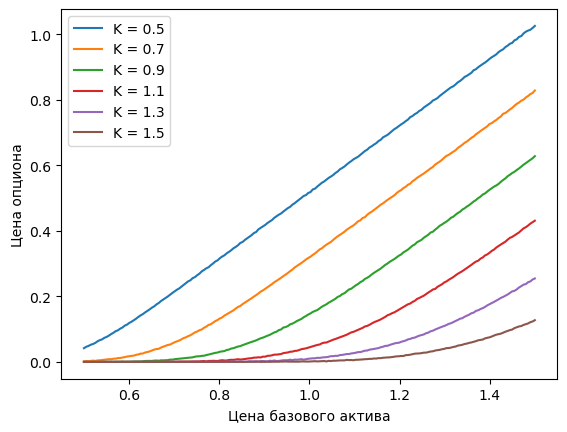

In [35]:
#Зависимость от страйка
T = 0.25
steps = 200
S_0 = np.linspace(0.5, 1.5, steps)
c = []
K_lst = [0.5, 0.7, 0.9, 1.1, 1.3, 1.5]
for K in K_lst:
    c = []
    print(K)
    for s_0 in S_0:
        model = ExpOU(s = s_0, v = 0.3, mu = 0.5, kappa = 0, sigma = 1, alfa = 0.5, theta = 0.2, beta = 0.4, rho = 0.25)
        res1 = monte_carlo(simulator = lambda paths: model.simulate_OU(T, steps, paths), 
                           f = lambda S: np.maximum(S[-1] - K, 0),
                           rel_err = 0.001)
        c.append(res1.x)
    c = np.array(c)
    plt.plot(S_0, c, label="K = {0}".format(K))
plt.xlabel("Цена базового актива")
plt.ylabel("Цена опциона")
plt.legend()
plt.show()

### Проверка на реальных данных ###

In [47]:
df = yf.download("GOOG", start="2022-12-16", end="2023-04-22")
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-15,93.540001,94.029999,90.430000,91.199997,91.199997,28298800
2022-12-16,91.199997,91.750000,90.010002,90.860001,90.860001,48485500
2022-12-19,90.879997,91.199997,88.925003,89.150002,89.150002,23020500
2022-12-20,88.730003,89.779999,88.040001,89.629997,89.629997,21976800
2022-12-21,89.730003,90.915001,88.910004,90.250000,90.250000,20336400
...,...,...,...,...,...,...
2023-04-17,105.430000,106.709999,105.320000,106.419998,106.419998,29043400
2023-04-18,107.000000,107.050003,104.779999,105.120003,105.120003,17641400
2023-04-19,104.214996,105.724998,103.800003,105.019997,105.019997,16732000


In [52]:
df_old = yf.download("GOOG", start="2020-01-10", end="2023-01-01")
price = df_old["Adj Close"]
ret = price.pct_change()
vol = ret.rolling(2).std().dropna() * np.sqrt(365/2)
np.std(vol) #estimation of vol of vol

[*********************100%***********************]  1 of 1 completed


0.2200628985497707

In [53]:
#df_opt = yf.download("GOOG230519C00100000", start="2023-02-21", end="2023-04-30", interval="1d")
df_opt = pd.read_csv("/Users/mac/Downloads/price-history-for-goog_20230421_90.00c-04-30-2023.csv")
df_opt = df_opt[86::-1].reset_index()
df_opt

,index,Time,Open,High,Low,Last,Change,Volume,Open Int,IV,Delta,Gamma,Theta,Vega,Rho,Theo,Price,Strike,Bid,Ask
0,86,12/15/2022,9.80,9.80,8.84,9.35,-3.15,102.0,1066.0,38.12%,0.594012,0.018988,-0.036754,0.207795,0.154741,9.350019,91.20,90.0,8.95,9.45
1,85,12/16/2022,9.10,9.10,8.50,8.50,-0.85,33.0,1127.0,36.97%,0.587394,0.019810,-0.035902,0.207004,0.152389,8.875012,90.86,90.0,8.70,9.05
2,84,12/19/2022,8.32,8.43,7.80,7.80,-0.70,776.0,1109.0,37.02%,0.551715,0.020734,-0.035823,0.203880,0.138336,7.800000,89.15,90.0,7.60,7.80
3,83,12/20/2022,7.35,7.66,7.30,7.66,-0.14,94.0,1857.0,36.22%,0.561187,0.021098,-0.035524,0.203442,0.140646,7.875000,89.63,90.0,7.80,7.95
4,82,12/21/2022,7.80,8.10,7.80,8.06,0.40,19.0,1838.0,35.58%,0.573666,0.021299,-0.035292,0.202904,0.143722,8.060000,90.25,90.0,7.95,8.15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,4,04/17/2023,16.18,16.50,15.55,16.50,-2.34,52.0,11496.0,86.48%,0.985428,0.004424,-0.063122,0.003565,0.007263,16.500000,106.42,90.0,16.10,16.90
83,3,04/18/2023,17.00,17.00,15.00,15.01,-1.49,80.0,11462.0,126.25%,0.956486,0.009388,-0.237933,0.007180,0.004670,15.325000,105.12,90.0,15.05,15.60
84,2,04/19/2023,14.25,15.75,14.23,15.75,0.74,119.0,11403.0,123.81%,0.992145,0.003166,-0.085269,0.001186,0.002442,15.050000,105.02,90.0,14.65,15.45
85,1,04/20/2023,15.36,16.50,15.36,16.10,0.35,186.0,11347.0,187.84%,0.957002,0.008837,-0.490571,0.005029,0.002302,16.100000,105.90,90.0,15.55,16.40


In [55]:
assert df.shape[0] == df_opt.shape[0]

In [56]:
import datetime

T = datetime.datetime(year=2023, month=4, day=21)
to_expiration = []
for i in range(df.shape[0]):
    to_expiration.append((T - df.index[i]).days / 365)
df["To Expiration"] = np.array(to_expiration)
df

,Open,High,Low,Close,Adj Close,Volume,To Expiration
Date,,,,,,,
2022-12-15,93.540001,94.029999,90.430000,91.199997,91.199997,28298800,0.347945
2022-12-16,91.199997,91.750000,90.010002,90.860001,90.860001,48485500,0.345205
2022-12-19,90.879997,91.199997,88.925003,89.150002,89.150002,23020500,0.336986
2022-12-20,88.730003,89.779999,88.040001,89.629997,89.629997,21976800,0.334247
2022-12-21,89.730003,90.915001,88.910004,90.250000,90.250000,20336400,0.331507
...,...,...,...,...,...,...,...
2023-04-17,105.430000,106.709999,105.320000,106.419998,106.419998,29043400,0.010959
2023-04-18,107.000000,107.050003,104.779999,105.120003,105.120003,17641400,0.008219
2023-04-19,104.214996,105.724998,103.800003,105.019997,105.019997,16732000,0.005479


In [57]:
#Historical Volatility
np.std(yf.download("GOOG", start="2021-01-01", end="2023-01-01")['Adj Close'].pct_change()) * np.sqrt(365)

[*********************100%***********************]  1 of 1 completed


0.38746459151771706

In [58]:
K = 90
def payoff(S: FloatArray):
    return np.maximum(S - K, 0)

In [63]:
#Подбор параметров
steps = 100
sigma_lst = [0.05, 0.1, 0.5, 1]
alfa_lst = [0.5]
theta_lst = [0.1, 0.4]
beta_lst = [0.2] #из [0.2, 0.4, 0.6] лучше всего показал себя 0.2
mu_lst = [1] #из [0.3, 0.5, 1, 1.5] лучше всего показал себя 1
rho_lst = [-0.5] #выяснилось, что лучше брать отрицательную корреляцию
_v = 0.4
_kappa = 0
sigma_opt = 0
alfa_opt = 0
theta_opt = 0
beta_opt = 0
mu_opt = 0
rho_opt = 0
err_opt = 10000
N = df.shape[0]
print(N)

for _sigma in sigma_lst:
    for _alfa in alfa_lst:
        for _theta in theta_lst:
            for _beta in beta_lst:
                for _mu in mu_lst:
                    for _rho in rho_lst:
                        print("Params: (sigma, alfa, theta, beta, mu, rho) = ", 
                              (_sigma, _alfa, _theta, _beta, _mu, _rho))
                        opt_price = []
                        for i in range(N):
                            s_0 = df.iloc[i]['Adj Close']
                            t = df.iloc[i]['To Expiration']
                            print("(s_0, t) = ", (s_0, t))
                            model = ExpOU(s=s_0, v=_v, mu=_mu, kappa=_kappa,sigma=_sigma, 
                                          alfa=_alfa, theta=_theta, beta=_beta, rho=_rho)
                            res = monte_carlo(simulator = lambda paths: model.simulate_euler(t, steps, paths), 
                                               f = lambda S: payoff(S),
                                               rel_err = 0.001)
                            print(res)
                            opt_price.append(res.x)
                        print(opt_price)
                        rel = abs(np.array(opt_price) - np.array(df_opt['Last'])) / np.array(df_opt['Last'])
                        rel_err = np.mean(rel)
                        print("Rel Err = ", rel_err)
                        if rel_err < err_opt:
                            sigma_opt = _sigma
                            alfa_opt = _alfa
                            theta_opt = _theta
                            beta_opt = _beta
                            mu_opt = _mu
                            rho_opt = _rho
                            err_opt = rel_err

87
Params: (sigma, alfa, theta, beta, mu, rho) =  (0.05, 0.5, 0.1, 0.2, 1, -0.5)
(s_0, t) =  (91.19999694824219, 0.34794520547945207)
MC(x=9.615063294654398, error=0.03243256158802866, conf_prob=0.95, success=False, iterations=1000000, control_coef=None)
(s_0, t) =  (90.86000061035156, 0.3452054794520548)
MC(x=9.328581210310597, error=0.031876750545419844, conf_prob=0.95, success=False, iterations=1000000, control_coef=None)
(s_0, t) =  (89.1500015258789, 0.336986301369863)
MC(x=8.09557960229236, error=0.0295385358363022, conf_prob=0.95, success=False, iterations=1000000, control_coef=None)
(s_0, t) =  (89.62999725341797, 0.33424657534246577)
MC(x=8.285791517532239, error=0.0296408600505027, conf_prob=0.95, success=False, iterations=1000000, control_coef=None)
(s_0, t) =  (90.25, 0.3315068493150685)
MC(x=8.600698123911284, error=0.0299140061386724, conf_prob=0.95, success=False, iterations=1000000, control_coef=None)
(s_0, t) =  (88.26000213623047, 0.3287671232876712)
MC(x=7.4125375635

KeyboardInterrupt: 

In [64]:
#Params: (sigma, alfa, theta, beta, mu, rho) =  (0.05, 0.5, 0.1, 0.2, 1, -0.5) после 1-й прогонки

In [65]:
df_opt['Last']

0      9.35
1      8.50
2      7.80
3      7.66
4      8.06
      ...  
82    16.50
83    15.01
84    15.75
85    16.10
86    15.70
Name: Last, Length: 87, dtype: float64

87
(s_0, t) =  (91.19999694824219, 0.34794520547945207)
MC(x=9.587415696464065, error=0.03235624788091151, conf_prob=0.95, success=False, iterations=1000000, control_coef=None)
(s_0, t) =  (90.86000061035156, 0.3452054794520548)
MC(x=9.317249120970452, error=0.03179976311091505, conf_prob=0.95, success=False, iterations=1000000, control_coef=None)
(s_0, t) =  (89.1500015258789, 0.336986301369863)
MC(x=8.08771891574752, error=0.029519249448364055, conf_prob=0.95, success=False, iterations=1000000, control_coef=None)
(s_0, t) =  (89.62999725341797, 0.33424657534246577)
MC(x=8.311466980770069, error=0.029701354169224113, conf_prob=0.95, success=False, iterations=1000000, control_coef=None)
(s_0, t) =  (90.25, 0.3315068493150685)
MC(x=8.609656492987629, error=0.029958721973392277, conf_prob=0.95, success=False, iterations=1000000, control_coef=None)
(s_0, t) =  (88.26000213623047, 0.3287671232876712)
MC(x=7.396871130397158, error=0.027923908104977815, conf_prob=0.95, success=False, iterati

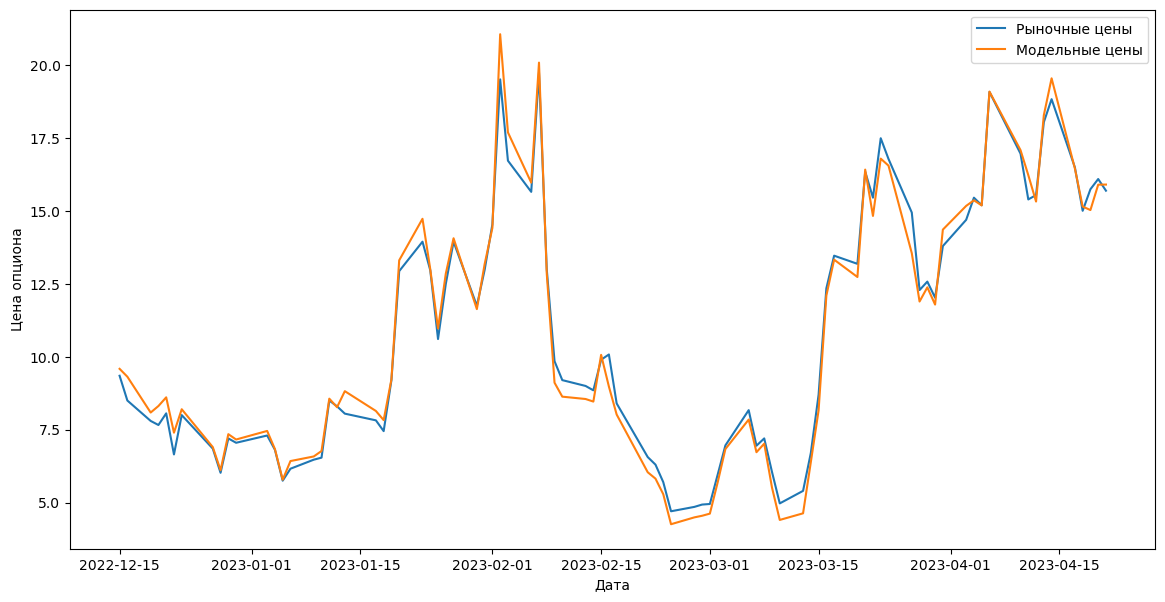

In [66]:
#Параметры для ExpOU
import timeit

K = 90
def payoff(S: FloatArray):
    return np.maximum(S - K, 0)

_sigma = 0.05
_alfa = 0.5
_theta = 0.1
_beta = 0.2
_rho = -0.5
_v = 0.4
_mu = 1
_kappa = 0
steps = 100

N = df.shape[0]
print(N)

opt_price = []
start = timeit.default_timer()
for i in range(N):
    s_0 = df.iloc[i]['Adj Close']
    t = df.iloc[i]['To Expiration']
    print("(s_0, t) = ", (s_0, t))
    model = ExpOU(s=s_0, v=_v, mu=_mu, kappa=_kappa,sigma=_sigma, 
                  alfa=_alfa, theta=_theta, beta=_beta, rho=_rho)
    res = monte_carlo(simulator = lambda paths: model.simulate_euler(t, steps, paths), 
                      f = lambda S: payoff(S),
                      rel_err = 0.001)
    print(res)
    opt_price.append(res.x)
print("Time = ", timeit.default_timer() - start)
err = np.mean(abs(np.array(opt_price) - np.array(df_opt['Last'])))
print("MAE = ", err)

r2 = 1 - np.std(np.array(opt_price) - np.array(df_opt['Last'])) / np.std(np.array(df_opt['Last']))
print("R2 = ", r2)
rel = abs(np.array(opt_price) - np.array(df_opt['Last'])) / np.array(df_opt['Last'])
print("Rel Err = ", np.mean(rel))

plt.figure(figsize=(14, 7))
plt.plot(np.array(df.index), np.array(df_opt['Last']), label="Рыночные цены")
plt.plot(np.array(df.index), np.array(opt_price), label="Модельные цены")
plt.legend()
plt.xlabel("Дата")
plt.ylabel("Цена опциона")
plt.show()

In [67]:
@dataclass
class BlackScholes:
    
    s: float
    sigma: float
    r: float = 0

    def _d1(self, t: Floats, k: Floats) -> Floats:
        """Computes `d_1` from the Black-Scholes formula."""
        return (np.log(self.s / k ) + (self.r + 0.5 * self.sigma**2) * t) / (self.sigma * np.sqrt(t))
    
    def _d2(self, t: Floats, k: Floats) -> Floats:
        """Computes `d_2` from the Black-Scholes formula."""
        return self._d1(t, k) - self.sigma * np.sqrt(t)

    def call_price(self, t: Floats, k: Floats) -> Floats:
        """Computes the price of a call option.

        Args:
          t: Expiration time (float or ndarray).
          k: Strike (float or ndarray).

        Returns:
          If `t` and `k` are scalars, returns the price of a call option as a
          scalar value. If `t` and/or `k` are arrays, applies NumPy
          broadcasting rules and returns an array of prices.

        Notes:
          For computation on a grid, use `call_price(*vol_grid(t, k))`, where
          `t` and `k` are 1-D arrays with grid coordinates.
        """
        return self.s * st.norm.cdf(self._d1(t, k)) - np.exp(-self.r * t) * k * st.norm.cdf(self._d2(t, k))

    def simulate(self, t: Floats, nsteps: int, npaths: int) -> FloatArray:
        """Simulates paths of the price process.

        Args:
          t: Time horizon.
          nsteps: Number of simulation points minus 1, i.e. paths are sampled
            at `t_i = i*dt`, where `i = 0, ..., nsteps`, `dt = t/nsteps`.
          npaths: Number of paths to simulate.

        Returns:
          An array `s` of shape `(nsteps+1, npaths)`, where `s[i, j]` is the
          value of `j`-th path at point `t_i`.
        """
        
        dt = t / nsteps
        
        z = (self.r - self.sigma**2 * 0.5) * dt + np.random.standard_normal(size=(nsteps, npaths)) * self.sigma * np.sqrt(dt)
        
        br_motion = np.concatenate([np.zeros((1, npaths)), np.cumsum(z, axis=0)])
        
        return self.s * np.exp(br_motion)


def bs_call_price(
    s: Floats,
    sigma: Floats,
    t: Floats,
    k: Floats,
    r: Floats = 0
) -> Floats:
    """Computes the Black--Scholes price of a call option.
    Args:
        s: Underlying asset price.
        sigma: Volatility.
        t: Expiration time.
        k: Strike.
        r: Interest rate.
    Returns:
        Call option price. If the arguments are arrays, applies NumPy
        broadcasting rules and returns the array of prices.
    Notes:
        This functions does the same computation as BlackScholes.call_price,
        but it allows to vectorize `s`, `sigma` and `r`.
    """
    d1 = (np.log(s/k) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))
    d2 = d1 - sigma * np.sqrt(t)
    
    return s * st.norm.cdf(d1) - np.exp(-r * t) * k * st.norm.cdf(d2)

(s_0, t) =  (91.19999694824219, 0.34794520547945207)
(s_0, t) =  (90.86000061035156, 0.3452054794520548)
(s_0, t) =  (89.1500015258789, 0.336986301369863)
(s_0, t) =  (89.62999725341797, 0.33424657534246577)
(s_0, t) =  (90.25, 0.3315068493150685)
(s_0, t) =  (88.26000213623047, 0.3287671232876712)
(s_0, t) =  (89.80999755859375, 0.32602739726027397)
(s_0, t) =  (87.93000030517578, 0.3150684931506849)
(s_0, t) =  (86.45999908447266, 0.31232876712328766)
(s_0, t) =  (88.94999694824219, 0.3095890410958904)
(s_0, t) =  (88.7300033569336, 0.30684931506849317)
(s_0, t) =  (89.69999694824219, 0.2958904109589041)
(s_0, t) =  (88.70999908447266, 0.29315068493150687)
(s_0, t) =  (86.7699966430664, 0.29041095890410956)
(s_0, t) =  (88.16000366210938, 0.2876712328767123)
(s_0, t) =  (88.80000305175781, 0.27945205479452057)
(s_0, t) =  (89.23999786376953, 0.27671232876712326)
(s_0, t) =  (92.26000213623047, 0.273972602739726)
(s_0, t) =  (91.91000366210938, 0.27123287671232876)
(s_0, t) =  (92.800

/var/folders/fw/5s9pnm2d27lfvkv814ljhz2c0000gn/T/ipykernel_39012/3188860184.py:78: RuntimeWarning: divide by zero encountered in double_scalars
  d1 = (np.log(s/k) + (r + 0.5 * sigma**2) * t) / (sigma * np.sqrt(t))


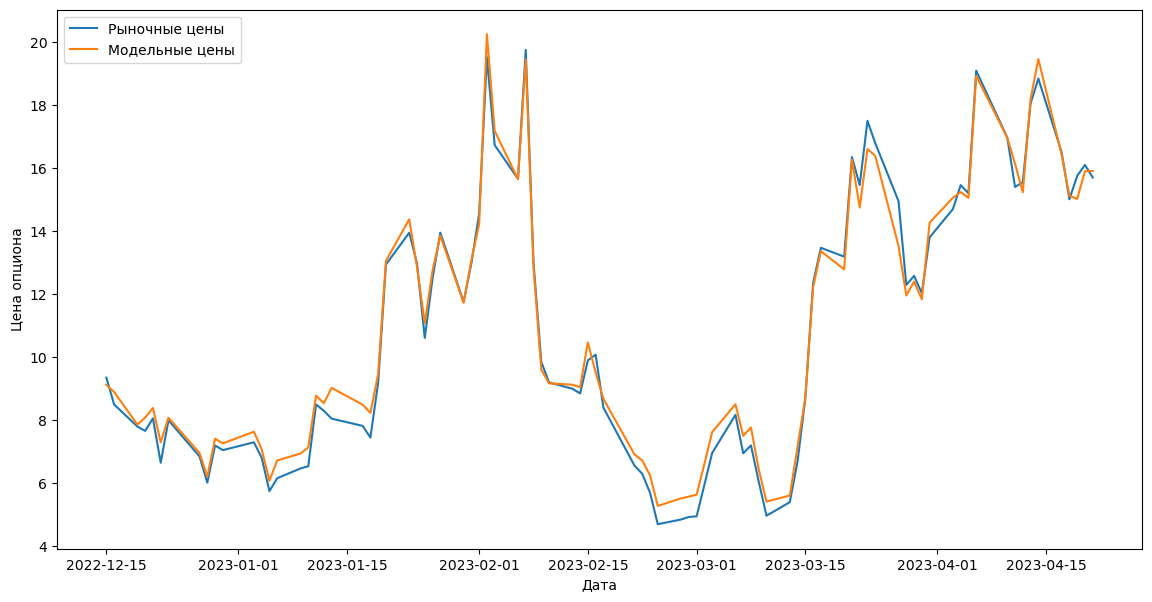

In [68]:
sigma = 0.4


opt_price_bs = []
start = timeit.default_timer()
for i in range(N):
    s_0 = df.iloc[i]['Adj Close']
    t = df.iloc[i]['To Expiration']
    print("(s_0, t) = ", (s_0, t))
    res = bs_call_price(s_0, sigma, t, 90, 0)
    opt_price_bs.append(res)
print("Time = ", timeit.default_timer() - start)

r2 = 1 - np.std(np.array(opt_price_bs) - np.array(df_opt['Last'])) / np.std(np.array(df_opt['Last']))
print("R2 = ", r2)
rel = abs(np.array(opt_price_bs) - np.array(df_opt['Last'])) / np.array(df_opt['Last'])
print("Rel Err = ", np.mean(rel))

plt.figure(figsize=(14, 7))
plt.plot(np.array(df.index), np.array(df_opt['Last']), label="Рыночные цены")
plt.plot(np.array(df.index), np.array(opt_price_bs), label="Модельные цены")
plt.legend()
plt.xlabel("Дата")
plt.ylabel("Цена опциона")
plt.show()